### ugrás ide <a id="top">

#### [package-ek és adat importálása](#import)
#### [explore feladatok](#exp)
#### [függvény feladatok](#func)
#### [plusz feladatok](#plusz)

------

### package-ek és adat importálása <a id="import">

In [144]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import glob
import json
from tqdm import tqdm_notebook as tqdm

In [2]:
message_files = sorted(glob.glob("data/*-msg.json"))

In [3]:
message_files

['data/2010-msg.json',
 'data/2011-msg.json',
 'data/2012-msg.json',
 'data/2013-msg.json',
 'data/2014-msg.json',
 'data/2015-msg.json',
 'data/2016-msg.json',
 'data/2017-msg.json',
 'data/2018-msg.json',
 'data/2019-msg.json',
 'data/2020-msg.json']

In [4]:
def get_data(path):

    with open(path, "r") as fp:
        file = json.load(fp)

    return file

In [5]:
data = pd.concat([pd.DataFrame(get_data(f)) for f in message_files]).reset_index(
    drop=True
)

In [6]:
data.head(5)

,index,sender_name,timestamp_ms,type,thread_path,thread_type,reactions,sticker,ip,photos,users,gifs,videos,content_l,datetime,year,month,day,hour,minute
0,1797,Colin Firth,1289492566000,Generic,622,Regular,[],None,None,0,[],0,0,8,2010-11-11T17:22:46.000Z,2010,11,11,17,22
1,1791,Colin Firth,1290522692000,Generic,622,Regular,[],None,None,0,[],0,0,84,2010-11-23T15:31:32.000Z,2010,11,23,15,31
2,76,Ronald Colman,1290789430000,Generic,809,Regular,[],None,None,0,[],0,0,1626,2010-11-26T17:37:10.000Z,2010,11,26,17,37
3,1,Barbra Streisand,1284905757000,Generic,29,RegularGroup,[],None,None,0,[],0,0,1323,2010-09-19T16:15:57.000Z,2010,9,19,16,15
4,19,Colin Firth,1293100456000,Generic,237,RegularGroup,[],None,None,0,[],0,0,57,2010-12-23T11:34:16.000Z,2010,12,23,11,34


-----

#### [vissza](#top)

### explore feladatok <a id="exp">

In [9]:
def sort_argmax(series, ascending=False, top_n=1):
    
    if top_n == 1:
        
        if ascending:
            
            return series.loc[lambda s: s == series.min()].sort_index().index[0]
        
        return series.loc[lambda s: s == series.max()].sort_index().index[0]

    top_values = series.sort_values(ascending=ascending).unique()[:top_n]
    
    return (np.concatenate([series
            .loc[lambda s: s == t]
            .sort_index()
            .index.tolist()
            for t in top_values])[:top_n])

In [10]:
def generic(df, g=True):
    
    if g:
        return df.loc[df["type"] == "Generic"]
    
    return df

In [11]:
setattr(pd.core.series.Series, "sort_argmax", sort_argmax)

In [12]:
setattr(pd.core.frame.DataFrame, "generic", generic)

1. Mi Hanga álneve? (1 pont)

In [68]:
hanga = data["sender_name"].value_counts().idxmax()

In [69]:
hanga

'Colin Firth'

2. Mi a jeszk-moments azonosítója? (2 pont)

In [15]:
jeszk = (
    data.groupby("thread_path").apply(lambda df: df["sender_name"].nunique()).idxmax()
)

In [16]:
jeszk

494

3. Ki írja átlagosan a leghosszabb üzeneteket? (2 pont)

In [259]:
data.generic().groupby("sender_name").mean()[
    "content_l"
].sort_argmax(top_n=5)

array(['Hugh Jackman', 'James Bond ', 'Stanley Tucci', 'Sophia Loren',
       'Barry Fitzgerald'], dtype='<U16')

In [18]:
# genericre szűrés nélkül
data.groupby("sender_name").mean()[
    "content_l"
].sort_argmax(top_n=5)

array(['Hugh Jackman', 'Mickey Mouse', 'James Bond ', 'Stanley Tucci',
       'Sophia Loren'], dtype='<U13')

4.A Ki iratkoztatott le legtöbbször a jeszk momentsből (2 pont)

In [266]:
data.loc[data["thread_path"] == jeszk].pipe(
    lambda df: df.loc[df["type"] == "Unsubscribe"]
).groupby("sender_name")["index"].count().sort_argmax(top_n=5)

array(['John Malkovich', 'Mahershala Ali', 'Batman', 'Chris Cooper',
       'Denzel Washington'], dtype='<U18')

4.B Kit iratkoztattak le legtöbbször a jeszk momentsből (2 pont)

In [326]:
pd.Series(data.loc[(data["thread_path"] == jeszk) & (data["type"] == "Unsubscribe"),
                   "users"].sum()).value_counts().sort_argmax(top_n=5)

array(['Chris Cooper', 'John Malkovich', 'Mahershala Ali',
       'Denzel Washington', 'Dorothy Malone'], dtype='<U18')

5. Ki küldte legtöbb képet a jeszk momentsbe? (2 pont)

In [269]:
data.loc[data["thread_path"] == jeszk].groupby(
    "sender_name")["photos"].sum().sort_argmax(top_n=5)

array(['Judy Holliday', 'Olivia de Havilland', 'Michael Douglas',
       'Naomi Watts', 'Holly Golightly '], dtype='<U19')

6. Hányan vannak, akik minden évben küldtek üzenetet? (3 pont)

In [21]:
data.generic().groupby("sender_name").apply(
    lambda df: df["year"].nunique()
).loc[lambda s: s == data["year"].nunique()].shape[0]

3

In [22]:
# genericre szűrés nélkül
data.groupby("sender_name").apply(lambda df: df["year"].nunique()).loc[
    lambda s: s == data["year"].nunique()
].shape[0]

3

7. Hányan vannak, akik pontosan n évben küldtek üzenetet ($ n = 1, ... 11 $) (2 pont, ábrázolásért +1)

In [23]:
n_years = (
    (
        pd.DataFrame(
            data.generic()
            .groupby("sender_name")
            .apply(lambda df: df["year"].nunique())
        )
        .reset_index()
        .rename(columns={0: "active years", "sender_name": "n_people"})
        .groupby("active years")
        .count()
    )
    .merge(
        pd.DataFrame(
            {"active years": np.arange(1, data["year"].nunique() + 1)}
        ).set_index("active years"),
        left_index=True,
        right_index=True,
        how="right",
    )
    .fillna(0)
).assign(n_people=lambda df: df["n_people"].astype(int))

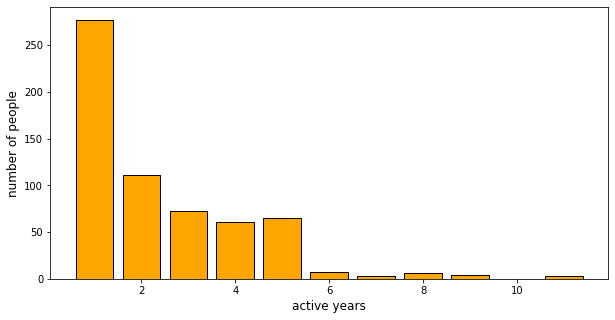

In [24]:
fig = plt.figure(figsize=(10, 5))
plt.bar(
    n_years.index.tolist(),
    n_years["n_people"].values,
    facecolor="orange",
    edgecolor="black",
)
plt.xlabel("active years", fontsize="large")
plt.ylabel("number of people", fontsize="large")
plt.show()

In [25]:
# genericre szűrés nélkül
n_years_2 = (
    (
        pd.DataFrame(data
                     .groupby("sender_name")
                     .apply(lambda df: df["year"].nunique())
                    )
        .reset_index()
        .rename(columns={0: "active years", "sender_name": "n_people"})
        .groupby("active years")
        .count()
    )
    .merge(
        pd.DataFrame(
            {"active years": np.arange(1, data["year"].nunique() + 1)}
        ).set_index("active years"),
        left_index=True,
        right_index=True,
        how="right",
    )
    .fillna(0)
).assign(n_people=lambda df: df["n_people"].astype(int))

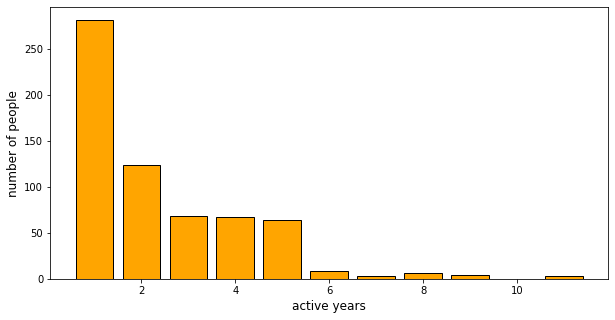

In [26]:
fig = plt.figure(figsize=(10, 5))
plt.bar(
    n_years_2.index.tolist(),
    n_years_2["n_people"].values,
    facecolor="orange",
    edgecolor="black",
)
plt.xlabel("active years", fontsize="large")
plt.ylabel("number of people", fontsize="large")
plt.show()

8. Ki van bent a második legtöbb csetben? (3 pont)

In [235]:
def set_of_users(df):
    
    return list(set(df["sender_name"])
                | set(sum(df["users"], []))
                | set(sum(df["reactions"], []))
                | {hanga})

In [236]:
memberships = pd.DataFrame(data.groupby("thread_path").apply(
    set_of_users)).rename(columns={0: "members"}).assign(
    n_members=lambda df: df["members"].apply(lambda l: len(l)))

In [272]:
pd.Series(sum(memberships["members"], [])).value_counts()[1:].sort_argmax(top_n=5)

array(['Mary J. Blige', 'Juliette Lewis', 'Tilda Swinton', 'James Coburn',
       'Lucas Hedges'], dtype='<U14')

9. Melyik a 2019-es db-cset? (akkor volt Hanga DB-tag) (5 pont)

In [28]:
db = (
    data.loc[data["year"] == 2019]
    .groupby("thread_path")
    .agg({"sender_name": ["nunique", "count"]})
    .loc[lambda df: df.loc[:, ("sender_name", "nunique")] == 13]
    .loc[:, ("sender_name", "count")]
    .idxmax()
)

In [29]:
db

797

10. Ki írta a legkevesebb üzenetet a 2019-es db-chatbe? (3 pont)

In [281]:
data.loc[data["thread_path"] == db].generic(
).groupby("sender_name")["index"].count().sort_argmax(ascending=True, top_n=5)

array(['Don Cheadle', 'Atticus Finch', 'Ray Milland', 'Glenn Close',
       'Adriana Barraza'], dtype='<U15')

In [31]:
# genericre szűrés nélkül
data.loc[data["thread_path"] == db].groupby("sender_name")["index"].count().sort_argmax(
    ascending=True, top_n=5
)

array(['Don Cheadle', 'Atticus Finch', 'Ray Milland', 'Glenn Close',
       'Adriana Barraza'], dtype='<U15')

11. Melyik az a cset, ahol a legtöbb idő telt el két ÜZENET között, és mennyi ez az idő? (4 pont)

In [283]:
data.generic().groupby("thread_path").apply(
    lambda df: df["timestamp_ms"].sort_values().diff().max()
).fillna(0).sort_values(ascending=False)[:5].apply(
    lambda s: f"{round(s / (1000 * 60 ** 2 * 24), 2)} days")

thread_path
865    1685.53 days
190    1460.94 days
267    1414.96 days
618    1337.65 days
300    1110.68 days
dtype: object

In [33]:
# genericre szűrés nélkül
data.groupby("thread_path").apply(
    lambda df: df["timestamp_ms"].sort_values().diff().max()
).fillna(0).sort_values(ascending=False)[:5].apply(
    lambda s: f"{round(s / (1000 * 60 ** 2 * 24), 2)} days")

thread_path
603     2609.7 days
865    1685.53 days
190    1460.94 days
267    1414.96 days
585    1402.62 days
dtype: object

12. Hány emberrel beszél Hanga 2015 óta minden évben, és hánnyal 2016 óta minden évben (rajkba kerülésének éve óta), és ez alapján kik a rajkosok ebből a listából? (4 pont)

In [34]:
df = (
    pd.DataFrame(
        data.groupby("sender_name").apply(lambda df: df["year"].sort_values().unique())
    )[0]
    .apply(lambda l: pd.Series(1, index=l))
    .fillna(0)
    .pipe(lambda df: df.rename(columns={c: str(c) for c in df.columns}))
).assign(
        from_2015=lambda df: df.apply(
            lambda r: bool(r[np.arange(2015, 2021).astype(str)].all()), axis=1),
        from_2016=lambda df: df.apply(
            lambda r: bool(r[np.arange(2016, 2021).astype(str)].all()), axis=1)
    )

In [35]:
df.iloc[:, -2:].sum()

from_2015     8
from_2016    56
dtype: int64

In [36]:
df.loc[~df["from_2015"] & df["from_2016"]].index.tolist()

['Abigail Breslin',
 'Bette Midler',
 'Billy Bob Thornton',
 'Casey Affleck',
 'Charles Laughton',
 'Chris Cooper',
 'Denzel Washington',
 'Don Ameche',
 'Ed Harris',
 'Ed Sheeran',
 'Floyd Mayweather, Jr.',
 'Gale Sondergaard',
 'Gary Sinise',
 'George Arliss',
 'George Burns',
 'George Lucas',
 'Grace Kelly',
 'Gwyneth Paltrow',
 'Hattie McDaniel',
 'Holly Golightly ',
 'James Coburn',
 'Jared Leto',
 'Jeff Bridges',
 'Joan Fontaine',
 'Joanne Woodward',
 'Judy Holliday',
 'Kate Winslet',
 'Kathleen Quinlan',
 'Katy Perry',
 'King Kong',
 'Lee Grant',
 'Leonardo DiCaprio',
 'Liza Minnelli',
 'Loretta Young',
 'Lucas Hedges',
 'Lynn Redgrave',
 'Marcia Gay Harden',
 'Mary J. Blige',
 'Mercedes Ruehl',
 'Meryl Streep',
 'Michael Douglas',
 'Miranda Richardson',
 'Naomi Watts',
 'Nicolas Cage',
 'Paul Newman',
 'Scarlett Johansson',
 'Teresa Wright',
 'Tom Wilkinson']

13. Ki érte el a legtöbb átlagos reakciót a jeszk momentsben? (4 pont)

In [289]:
data.loc[data["thread_path"] == jeszk].groupby("sender_name").apply(
    lambda df: df["reactions"].apply(lambda x: len(x)).mean()
).sort_argmax(top_n=5)

array(['Ginger Rogers', 'Kevin Kline', 'Jessica Chastain',
       'Sylvester Stallone', 'Batman'], dtype='<U18')

-----

#### [vissza](#top)

### függvény feladatok <a id="func">

14. Megadok egy timestamp-et, ki az eddig az időpontig írt leghosszabb üzenet szerzője? (1 pont)

In [295]:
def longest_mess(timestamp=1293114321000, g=True, top_n=1):
    
    return data.loc[data["timestamp_ms"] <= timestamp].generic(g).set_index(
        "sender_name")["content_l"].sort_argmax(top_n=top_n)

In [296]:
longest_mess(top_n=5)

array(['Colin Firth', 'Ruby Dee', 'The Tramp ', 'Colin Firth', 'Ruby Dee'],
      dtype='<U13')

In [292]:
# genericre szűrés nélkül
longest_mess(g=False, top_n=5)

array(['Colin Firth', 'Ruby Dee', 'The Tramp ', 'Colin Firth', 'Ruby Dee'],
      dtype='<U13')

15. Megadok egy timestamp-et, melyik óra eddig az időpontig a legkevésbé aktív, amiben legalább egy interakció lezajlott? (tehát nem 0 az aktivitás) (1 pont)

In [186]:
def inactive_hour(timestamp=1293114321000, top_n=1):

    return (
        data.loc[data["timestamp_ms"] <= timestamp]
        .groupby("hour")["index"]
        .count()
        .sort_argmax(ascending=True, top_n=top_n)
    )

In [187]:
inactive_hour(top_n=5)

array([ 9, 23, 12, 22, 14])

16. Megadok egy timestamp-et és egy embert, mondd meg, hány karaktert küldött eddig az időpontig (2 pont)

In [309]:
def sent_chars(person, timestamp=1293114321000, g=True):

    return (data.loc[(data["timestamp_ms"] <= timestamp)
                     & (data["sender_name"] == person)]
            .generic(g)["content_l"].sum())

In [310]:
sent_chars("Juliette Lewis")

4252

In [306]:
# genericre szűrés nélkül
sent_chars("Juliette Lewis", g=False)

4252

17. Megadok egy timestamp-et, hányan írtak eddig az időpontig legalább 10 üzenetet? (3 pont)

In [311]:
def at_least_ten_mess(timestamp=1293114321000, g=True):

    return (
        data.loc[data["timestamp_ms"] <= timestamp]
        .generic(g)
        .groupby("sender_name")["index"]
        .count()
        .loc[lambda s: s >= 10]
        .shape[0]
    )

In [312]:
at_least_ten_mess()

2

In [313]:
# genericre szűrés nélkül
at_least_ten_mess(g=False)

2

18. Megadok egy timestamp-et, melyik volt a top5 legaktívabb cset eddig az időpontig (4 pont)

In [49]:
def top5_most_active(timestamp=1293114321000):

    return (
        data.loc[data["timestamp_ms"] <= timestamp]
        .groupby("thread_path")["index"]
        .count()
        .sort_argmax(top_n=5)
    )

In [50]:
top5_most_active()

array([ 32, 237, 622, 360, 546])

19.1 Megadok egy timestamp-et és egy csetet (thread_id), összesen hány különböző ember írt, összesen hány üzenetet és hány karaktert írtak eddig az időpontig? (4 pont)

In [51]:
def people_mess_chars(thread, timestamp=1293114321000, g=True):

    return data.loc[
        (data["timestamp_ms"] <= timestamp)
        & (data["thread_path"] == thread)
    ].generic(g).agg({"sender_name": "nunique", "index": "count", "content_l": "sum"})

In [52]:
people_mess_chars(237)

sender_name      5
index           17
content_l      930
dtype: int64

In [53]:
# genericre szűrés nélkül
people_mess_chars(237, g=False)

sender_name      5
index           17
content_l      930
dtype: int64

19.2 Emberenként csoportosítva hány üzenetet és hány karaktert küldtek? (+2 pont)

In [54]:
def people_mess_chars_2(thread, timestamp=1293114321000, g=True):

    return (
        data.loc[
            (data["timestamp_ms"] <= timestamp)
            & (data["thread_path"] == thread)
        ].generic(g)
        .groupby("sender_name")
        .agg({"content_l": ["count", "sum"]})
    )

In [55]:
people_mess_chars_2(237)

content_l     
                     count  sum
sender_name                    
Barbra Streisand         3  274
Colin Firth              3  126
Juliette Lewis           7  417
Ruby Dee                 1   50
U2                       3   63

In [56]:
# genericre szűrés nélkül
people_mess_chars_2(237, g=False)

content_l     
                     count  sum
sender_name                    
Barbra Streisand         3  274
Colin Firth              3  126
Juliette Lewis           7  417
Ruby Dee                 1   50
U2                       3   63

20. Megadok egy órát, átlagosan hány üzenetet küldtek ebben az órában az összes olyan napra átlagolva, amikor küldtek üzenetet? (5 pont)

In [314]:
def mess_by_hour(hour, g=True):

    return (
        data.loc[data["hour"] == hour]
        .generic(g)
        .groupby(["year", "month", "day"])
        .count()["index"]
        .mean()
    )

In [315]:
mess_by_hour(17)

13.714360587002096

In [317]:
# genericre szűrés nélkül
mess_by_hour(17, g=False)

13.735033836543467

21. Megadok egy timestamp-et, melyik csetbe és kicsoda írta  eddig az időpontig a legtöbb karaktert (5 pont)

In [188]:
def most_chars(timestamp=1293114321000, g=True, top_n=1):

    return (
        data.loc[data["timestamp_ms"] <= timestamp]
        .generic(g)
        .groupby(["thread_path", "sender_name"])["content_l"]
        .sum()
        .sort_argmax(top_n=top_n)
    )

In [189]:
most_chars(top_n=5)

array([['622', 'Colin Firth'],
       ['809', 'Ronald Colman'],
       ['331', 'Colin Firth'],
       ['585', 'Ruby Dee'],
       ['679', 'The Tramp ']], dtype='<U21')

In [190]:
# genericre szűrés nélkül
most_chars(g=False, top_n=5)

array([['622', 'Colin Firth'],
       ['809', 'Ronald Colman'],
       ['331', 'Colin Firth'],
       ['585', 'Ruby Dee'],
       ['679', 'The Tramp ']], dtype='<U21')

22. Megadok egy timestamp-et, mi volt a leghosszabb periódus eddig az időpontig üzenet nélkül (7 pont)

In [191]:
def longest_silent_period(timestamp=1293114321000, g=True, top_n=1):

    return (
        data.generic(g).loc[lambda df: df["timestamp_ms"] <= timestamp, "timestamp_ms"]
        .sort_values()
        .diff()
        .sort_values(ascending=False)[:top_n]
        .values
    )

In [319]:
longest_silent_period(top_n=5)

array([1.1531014e+10, 3.8184020e+09, 1.3003870e+09, 1.0278930e+09,
       1.0250950e+09])

In [320]:
# genericre szűrés nélkül
longest_silent_period(g=False, top_n=5)

array([1.1531014e+10, 3.8184020e+09, 1.3003870e+09, 1.0278930e+09,
       1.0250950e+09])

--------

#### [vissza](#top)

### plusz feladatok <a id="plusz">

23. Kinek üzent először Hanga? (1 pont)

In [81]:
[n for n in data.loc[data["thread_path"] == data.loc[data["sender_name"] == hanga].sort_values(
    by="datetime").generic().iloc[0]["thread_path"], "sender_name"].unique() if n != hanga]

['Judy Sheindlin']

24. Mi Fenyő álneve? (3 pont)

In [84]:
data.loc[data["thread_path"] == jeszk].sort_values(by="datetime").iloc[0]["sender_name"]

'Leonardo DiCaprio'

25. Mi Hanga évfolyamchatének indexe? (2 pont)

In [97]:
data.loc[data["year"] >= 2016].groupby("thread_path")["sender_name"].nunique(
).loc[lambda s: s == 21].index.tolist()[0]

558

26. Mi a legfiatalabb szmt tag - Laufer Zoli - álneve? (3 pont)

In [1]:
'Broderick Crawford'

'Broderick Crawford'

27. Hanga melyik évben vált a legtöbb csoport tagjává? (2 pont?)

In [322]:
data.groupby("thread_path")[["year"]].min().merge(
    memberships.loc[lambda df: df["n_members"] > 2],
    left_index=True, right_index=True, how="right").reset_index(
).groupby("year")["thread_path"].count().sort_argmax(top_n=5)

array([2018, 2019, 2017, 2016, 2011])

28. Milyen hosszú az az üzenet, ami a legtöbb reakciót kapta? (3 pont)

In [194]:
data.loc[data["reactions"].apply(lambda l: len(l)).sort_argmax(top_n=5), "content_l"]

296150    109
293981      0
204377     26
264655      0
312867      0
Name: content_l, dtype: int64

29. Melyik csoportos chatben küldték a legtöbb üzenetet a résztvevők számához viszonyítva (összes üzenetek száma / összes egyedi ember aki valaha tagja volt a csoportnak) (5 pont)

In [239]:
memberships.loc[lambda df: df["n_members"] > 2].merge(
    data.generic().groupby("thread_path")[["index"]].count(
    ).rename(columns={"index": "n_mess"}),
    left_index=True, right_index=True, how="left").assign(
    rel_act=lambda df: df["n_mess"] / df["n_members"])["rel_act"].sort_argmax(top_n=5)

array([858, 454, 857, 356, 671])